# REINFORCE algorithm 

In this notebook I implemented REINFORCE algorithm on the cartpole environment from gym. I also used the same algorithm to observe its performace on different environments (mountaincar and cartpole). 
Originally I tried to resolve the mountaincar continuous environment. In this environment the limit number of steps for a trial is 1000. The agent is getting a penalty when choosing to perform actions and if the car manages to reach the goal - a huge reward of 200 is given. 
I tried different network hierarchies, learning rate, initializations. The result was that the car stayed almost with no movements in the valey. Then adding internal reward that is proportional to the car's distance from the initial point it got stucked in local minima of oscillating in the valey, and unfortunately a penalty for episodes that don't result with success did not help. It was then clear that the policy gradient method is not adequate to the conditions of the problem. Also the variance in the rewards (200 or a negative result) might make it harder to trace the gradient. In addition it is possible that with recurrent network, the agent would have kind of memory, which might enable to learn situation like: if you are dragged up to the other hill (he distant from the target) - don't try to resist, but try to reach as high as possible in order to build momentum.   

To use the algorithm I wrote it was needed to make some small changes from continuous action space to discrete. With the cartpole we need to keep the pole upright, for 200 time steps, when +1 reward is recieved for a "successful time step". That means that an episode with accumulated reward of 200 means that the goal was fulfilled. In this environment a success is defined having an average reward of over 195 on 100 consequent episodes.   

#### About the implemetation : 
I use a class which I called "reinforce", that extends nn.Module. 
The class implements the following hierarchy for the above purposes:
Two fully connected layers with relu as activation function and finally another fully connected layer. 
In the class I maintain some values:
*action_memory* - which is a list that accumulates the actions performed in an episode (trajectory). This is gets empty after using the information for learning (update_policy)
*reward_memory* - which is a list that contains all the rewards from the current trajectory until it gets empty in the same way as "action_memory" list.
In the class I also implemeted the following methods:
*forward* that defines the order and use of the layers. 
*act* is the function that outputs the chosen action for the given state. 
*store_reward* is for storing the current reward in "self.reward_memory" list.
*update_policy* is a very important method, where the learning actually happens. Also this method return the loss so it can be saved. 

The main script contains an outer loop for number of episodes and an inner loop for the steps (state, action, reward, state) of each episode. 

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import math 
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
import torch.nn.functional as F
import tensorflow as tf
# torch.autograd.set_detect_anomaly(True)
from IPython.display import clear_output

In [2]:
env = gym.make("CartPole-v0")
# env = gym.make("Acrobot-v1")
# env = gym.make("MountainCar-v0")
print('Actions  : ',env.action_space)  
print('Variables: ',env.observation_space)
print('Max. var: ',env.observation_space.high)
print('Min. var: ',env.observation_space.low)

Actions  :  Discrete(2)
Variables:  Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)
Max. var:  [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
Min. var:  [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]


In [3]:
class reinforce(nn.Module):
    def __init__(self, alpha, hidden_size1, hidden_size2, num_inputs, num_outputs):
        super(reinforce, self).__init__()
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.action_memory = []
        self.reward_memory = []
        self.linear1 = nn.Linear(num_inputs, hidden_size1)
        self.linear2 = nn.Linear(hidden_size1, hidden_size2)
        self.pi = nn.Linear(hidden_size2, num_outputs)  # pi is the policy, the output of the network that contains 2 outputs
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu') # I used GPU for the processing
        self.optimizer = optim.Adam(self.parameters(), lr=alpha) #Adam optimizer with its default parameters, except alpha that is received in the construction. 
        self.to(self.device)

    def forward(self, obs):
        state = T.tensor(obs, dtype=T.float).to(self.device) 
        x = F.relu(self.linear1(state)) 
        x = F.relu(self.linear2(x))
        pi = self.pi(x)
        return pi
    
    
    def act(self, state):
        distribution = F.softmax(self.forward(state))
        probs_action = T.distributions.Categorical(distribution) #action distribution according to our model
        action = probs_action.sample()  #single continuous quantity the distribution
        log_probs = probs_action.log_prob(action).to(self.device)  # log of the probability of the action given the current state
        self.action_memory.append(log_probs) # add the log of probability for this action for the long time  reward calc later
        return action.item()
    
        
    def update_policy(self,  gamma): 
        self.optimizer.zero_grad()  #zero up gradients since pytorch accumulates in "backward()"
        discounted_rewards = []
        for t in range(len(self.reward_memory)):  # running through the rewards accumulated durring the episode
            #we want to calculate the actual reward taking into consideration the discount factor.
            #to this end we need to go through all the steps, and for each one to calculate the rewards of the following steps.
            # those following steps rewards are updated and the are different when we are in one step or another.
            Rt = 0 #the long time reward for time step t            
            pwr = 0 #the power of the gamma
            for r in self.reward_memory[t:]:  # run from current time step reward until the end of the episode
                Rt = Rt + gamma**pwr * r 
                pwr = pwr + 1  # power of gamma increase by 1 in each step
            discounted_rewards.append(Rt)
        std = np.std(discounted_rewards) if np.std(discounted_rewards) > 0 else 1
        mean = np.mean(discounted_rewards)
        discounted_rewards = (discounted_rewards - mean) / std
        #I chose to perform a normalization of the discounted reward since it helped me stabilize the learning (less variance)
        discounted_rewards = T.tensor(discounted_rewards, dtype=T.float).to(self.device)
        #now we will calculate the loss function
        #the loss is caclulated with using each of the long time return per time step multiplied with log of probabilities for actions that we stored in action_memory
        loss = 0
        for log_prob, Rt in zip(self.action_memory, discounted_rewards):
            loss += -log_prob * Rt  # with minus since we do gradient ascent
            
        loss.backward() 
        self.optimizer.step()
        self.action_memory = [] #reset the memory for the next episode
        self.reward_memory = []
        
        return loss.item()  #returning the loss for plotting purposes

In [4]:
def smoothen(data,window_width):
    cumsum_vec = np.cumsum(np.insert(data, 0, 0)) 
    return (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width

def plot(rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('reward')
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()
    
def plot_smooth(rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('reward')
    plt.plot(smoothen(rewards,100))
    plt.subplot(132)
    plt.title('loss')
    plt.plot(smoothen(losses,100))
    plt.show()

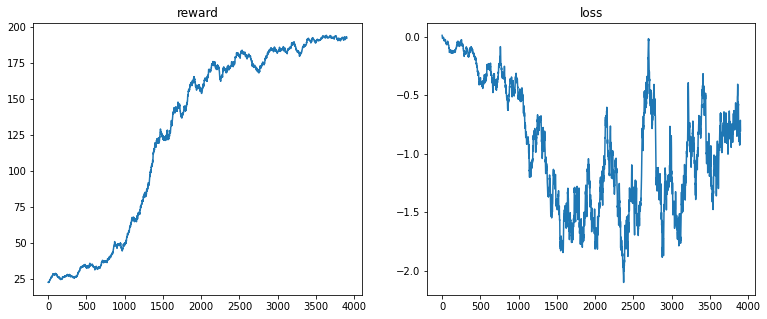

mean number of states per episode is: 127.19720069982505


C:\Users\Tair\.conda\envs\reinforce\lib\site-packages\ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\Tair\.conda\envs\reinforce\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Episode: 4010, reward: 200.0
Episode: 4020, reward: 200.0
Episode: 4030, reward: 200.0
Episode: 4040, reward: 200.0
Episode: 4050, reward: 200.0
Episode: 4060, reward: 200.0
Episode: 4070, reward: 200.0
Goal Achieved - average of above 195 over 100 consequent episodes
Current episode is  4079  and the first time goal accomplished in this combo is  3979


In [5]:
print('Actions  : ',env.action_space) 
n_hidden_units1 = 128 # network with 128 units in each of the two FC layers.
n_hidden_units2 = 128

theta_net = reinforce(0.00005, n_hidden_units1, n_hidden_units2, env.observation_space.shape[0], 2)
n_episodes = 5000  #setting this number but hopefully will be able to converge earlier
R_total = [] # list of all the rewards recieved from the different apisodes. This will have the length of # of episodes
loss = [] # list of all the losses calculated from the different apisodes. This will have the length of # of episodes
gamma = 0.99
render = True
n_steps_per_episode = []  #list of counters of states the agent went through in all episodes.This will have the length of # of episodes
for i in range(n_episodes):
    state = T.Tensor([env.reset()])  #intialization of the episode
    done = False
    state_list = [] #all the states accumulated for current episode
    state_list.append(state)
    score = 0  # the accumulative reward (not for the episode)
    while done!=True:  #generate an episode
        if render and i%50 == 0:
            env.render()
        action = theta_net.act(state) 
        obs, r, done, info = env.step(action)
        theta_net.reward_memory.append(r)
        state_list.append(obs)
        state = T.Tensor([obs])  # current step updated
        score += r
    n_steps_per_episode.append(len(state_list))
    R_total.append(score)
    loss.append(theta_net.update_policy(gamma))  #update the policy (learning)
    
    if i%10 == 0:
        print("Episode: {}, reward: {}".format(i, score))

    if i%200 == 0:
        plot_smooth(R_total, loss)
        print("mean number of states per episode is: " + str(np.mean(n_steps_per_episode)))
    if np.mean(R_total[-100:]) > 195:  # Success criteria - early stopping
        print("Goal Achieved - average of above 195 over 100 consequent episodes")
        print("Current episode is ", i, " and the first time goal accomplished in this combo is ", i-100)
        break

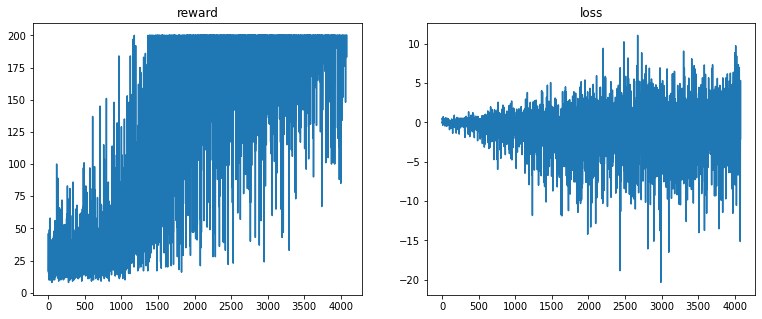

In [6]:
print("Average reward over last 100 episodes " + str(np.mean(R_total[-100:])))
print("First time 200 points in an episode: EPISODE number " + str(np.argmax(R_total))) #The first episode 200 points were collected
plot(R_total, loss)

### Insights from the graphs
In the above graphs we can see the a smoothen and a non-smoothen versions of the rewards and losses during the training. In those two last graphs the variance is very present and exemplifies the disadvantage of this method. 
In the loss graph it is hard to see the trend, so the smoothen version does a better job for the progress decripsion. In the smoothen version of the loss we can see a gradual decrease that teaches us that the agent learns. After approximately 1500 the loss - the trend is not stable and we can see it fluctuating for relatively long period. In parallel, observing the reward not smoothen version we can see that around 2000 episodes - the probability to end an episode with success increases a lot. From this phase it looks like stabilization for 1000-2000 episodes (might change in different execution). 
Having a positive reward for each time step it is able to have the pole upright, the algorithm was able to learn the objective and converge to the goal within approximately 4079 episodes.

In [7]:
#saving model
# PATH = 'C:/Users/Tair/PycharmProjects/semster2/ATCI/models/'
# T.save(theta_net.state_dict(), PATH+"cartpole")
# # 128, 128
# # save outputs
# with open("outputs.txt", "w") as f:
#     for i in range(len(R_total)):
#         f.write(str(R_total[i]) +"," + str(loss[i]) + "," + str(n_steps_per_episode[i]) + ";")

#### In the following block it is possible to see an example demo of an episode:

In [8]:
# demo of the result:
# demo_model = theta_net  #in case we are right after training
# demo_model = reinforce(0.00005, n_hidden_units1, n_hidden_units2, env.observation_space.shape[0], 2)
# demo_model.load_state_dict(T.load(PATH+"cartpole"))
score = 0
state = T.Tensor([env.reset()])
done = False
while done!=True:
    env.render()
    action = theta_net.act(state) 
    obs, r, done, info = env.step(action)
    state = T.Tensor([obs])  # current step updated
    score += r
print(score)

C:\Users\Tair\.conda\envs\reinforce\lib\site-packages\ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\Tair\.conda\envs\reinforce\lib\site-packages\ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


200.0


In [9]:
env.close()

## Some discussion and conclusions

We can see that the cartpole problem was solved using reinforce discrete policy gradient method. Reinforce algorithm with a relatively simple hierarchy of 3 layers is able to tackle this problem. It was important to initializez the wights of the network before training.


### REINFORCE vs q-learning
If we compare reinforce to q-learning (based on notebook of lab4):
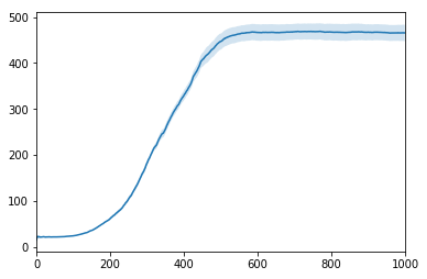
we can see that q-learning was able to learn faster, and to solve the problem in less episodes significantly (order of magnitude). Q-learning is based on the value function of the stated and for this kind of problem it shows it's advantage. Reinforce does not consider at the value function. Applying baseline we would probably be witnessed to faster convergence of the one of Reinforce.

### REINFORCE on different environments:

**acrobot**

I applied the same algorithm with acrobot environment where we have 2 linked pendulums, and the goal is for the second (not fixed) pendulum to reach a certain height, by choose action of adjusting the angle between them. In each episode there are maximum of 500 steps and for each step reward of -1 is received, so every episode resulting with more than -500 score - is an episode where the goal was fulfilled. 
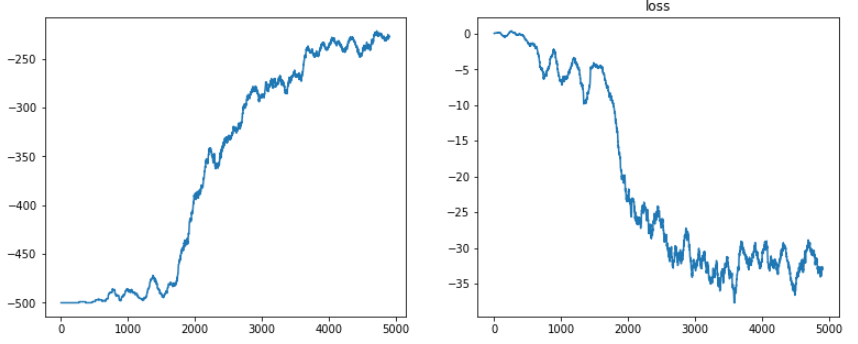
Applying this reinforce algorithm on acrobot (I let it run for 5000 iterations training) resulted with learning after approximately 1500 episodes. Then we can see the loss starting to decrease significantly while the reward is in the rise. By the episode number 2500 - all the following episodes result with success. 


**mountaincar discrete**

Another try to apply the algorithm on the discrete mountaincar environment has been performed, and it failed to learn after 5,000 iterations. It was also impossible to see any trend of learning as it can be seen in the following graph:
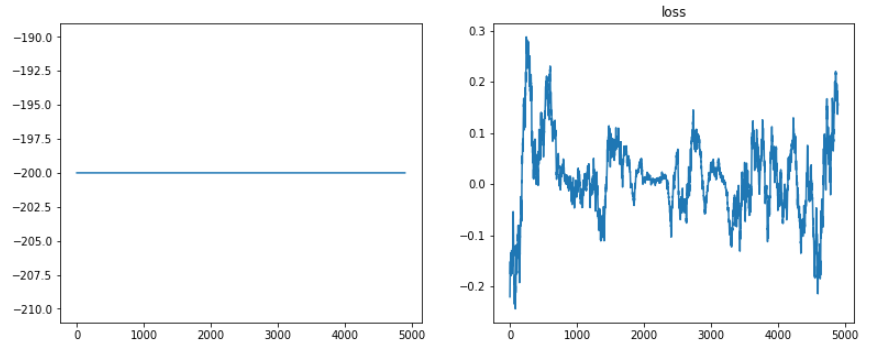
Mountaincar discrete environement works rewarding -1 for each time step that the car is not in the desired point -the top of mountain to the right. For the time step the car is in the desired spot it recieves a reward of 0. This is aim to train the car to do the fasted scenario in order to reach the goal. The car needs to build up a momentum but the way that it is rewarded does not allow it to learn via policy gradient. To some extent this is similar to the other 2 environments above but apparently it is more complicated. More exploration is needed since the agent might experience 5000 tries with not even one success. I try to cause more exploration with weight initialization of the network but the results were the same. In addition it is possible that 200 steps is not long enough for the car to perform suffieicently movements for this type of learning. 


First, as stated in the begining of the notebook, the reward function is crucial. Some algorithms work better than others in different conditions. For moauntain car and cartpole q-learning would have performed better. It is important to make sure that the method we apply corresponds the problem conditions, or to make the needed changes in the environment (like internal reward), but it also appears to be a tough task. 
I have learned a lot from this task both in the thoretical as in the practical aspect.
Thank you.